In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
import matplotlib.pyplot as mp
from keras.regularizers import l2

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('test_images.zip','r')
zip_ref.extractall('test')
zip_ref.close()

In [ ]:
zip_ref=zipfile.ZipFile('train_images.zip','r')
zip_ref.extractall('train')
zip_ref.close()

In [ ]:
im = plt.imread("test/test_images/1/cat.3897.jpg")
plt.imshow(im)
plt.show()

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    directory = 'train/train_images',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

validation_ds = keras.utils.image_dataset_from_directory(
    directory = 'test/test_images',
    labels='inferred',
    label_mode = 'int',
    batch_size=32,
    image_size=(256,256)
)

Found 880 files belonging to 2 classes.
Found 220 files belonging to 2 classes.


In [ ]:
# Normalize
def process(image,label):
    image = tf.cast(image/255. ,tf.float32)
    return image,label

train_ds = train_ds.map(process)
validation_ds = validation_ds.map(process)

In [ ]:
# create CNN model

model = Sequential()

model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(256,256,3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

model.add(Flatten())

model.add(Dense(128,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64,activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 254, 254, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Bat  (None, 125, 125, 64)      256       
 chNormalization)                                                
                                                        

In [ ]:
model.summary()

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

In [ ]:
history = model.fit(train_ds,epochs=10,validation_data=validation_ds)

Epoch 1/10
28/28 [==============================] - 198s 7s/step - loss: 5.0051 - accuracy: 0.5580 - val_loss: 34.2394 - val_accuracy: 0.5000
Epoch 2/10
28/28 [==============================] - 179s 6s/step - loss: 2.5394 - accuracy: 0.6034 - val_loss: 3.6263 - val_accuracy: 0.5091
Epoch 3/10
28/28 [==============================] - 186s 7s/step - loss: 1.6338 - accuracy: 0.6750 - val_loss: 1.9037 - val_accuracy: 0.5091
Epoch 4/10
28/28 [==============================] - 186s 7s/step - loss: 1.4019 - accuracy: 0.7011 - val_loss: 1.5127 - val_accuracy: 0.4636
Epoch 5/10
28/28 [==============================] - 186s 7s/step - loss: 1.1079 - accuracy: 0.7602 - val_loss: 1.4336 - val_accuracy: 0.5636
Epoch 6/10
28/28 [==============================] - 186s 7s/step - loss: 0.6422 - accuracy: 0.8341 - val_loss: 2.1989 - val_accuracy: 0.5909
Epoch 7/10
28/28 [==============================] - 184s 7s/step - loss: 0.5669 - accuracy: 0.8432 - val_loss: 1.8569 - val_accuracy: 0.5682
Epoch 8/10
2

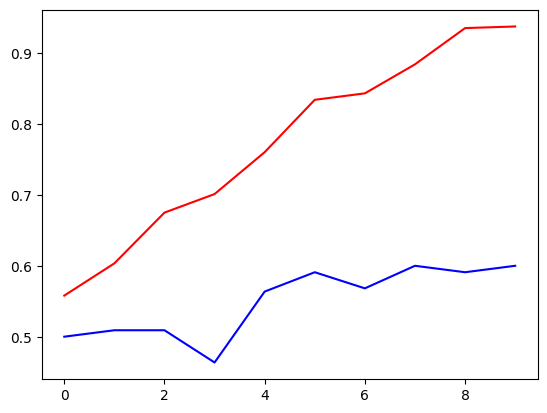

In [ ]:
mp.plot(history.history['accuracy'],color='red',label='train')
mp.plot(history.history['val_accuracy'],color='blue',label='test')

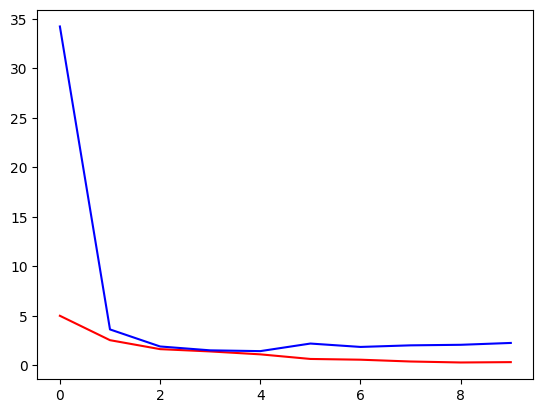

In [ ]:
mp.plot(history.history['loss'],color='red',label='train')
mp.plot(history.history['val_loss'],color='blue',label='test')

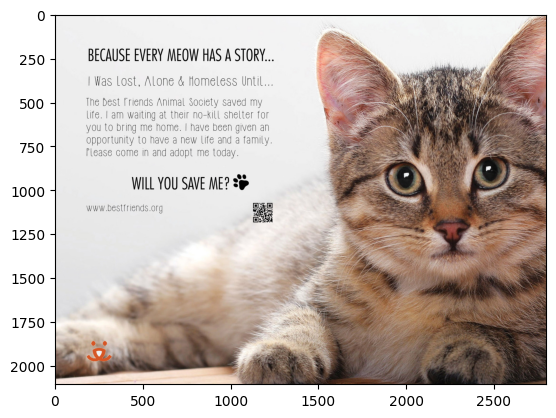

In [ ]:
tmp_img = plt.imread("cat.jpg")
plt.imshow(tmp_img)
plt.show()

In [ ]:
import cv2 as c

In [ ]:
temp_img=c.resize(tmp_img,(256,256))

In [ ]:
tm_inp=temp_img.reshape((1,256,256,3))

In [ ]:
if (model.predict(tm_inp))==1:
    print("DOG")
else:
    print("CAT")

1/1 [==============================] - 0s 78ms/step
CAT


In [ ]:
model.save('cat_vs_dog_cnn')

In [ ]:
import shutil
shutil.make_archive('cat_vs_dog_cnn', 'zip', 'cat_vs_dog_cnn')

'/content/cat_vs_dog_cnn.zip'

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

import pathlib
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import random
import numpy as np
import os
from glob import glob
from tqdm import tqdm
import requests
import cv2
from PIL import Image

In [ ]:
def extract_ground_truth(path):
    """Extracts ground truths like boxes, labels and ids from xml files."""

    boxes = []
    labels = []
    ids = []

    tree = ET.parse(path)
    id_i = path.split("/")[-1].split(".")[1]
    objects = tree.getroot().findall("object")

    for object_i in objects:
        object_name = object_i.find("name").text
        if object_name=="cat":
            instances = object_i.findall("bndbox")
            for instance in instances:
                xmin = int(float(instance.find("xmin").text))
                xmax = int(float(instance.find("xmax").text))
                ymin = int(float(instance.find("ymin").text))
                ymax = int(float(instance.find("ymax").text))
                box = np.array([xmin, xmax, ymin, ymax])
                boxes.append(box)
                labels.append(object_name)
                ids.append(id_i)
        return np.array(boxes), np.array(labels), np.array(ids) #We will only consider last item, can be changed in future iterations

In [ ]:
def region_proposals(image):
    """Generates region proposals using Selective Search"""
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    rects = ss.process()

    prediction_rects = _restructure_rectangles_xx(rects)
    return prediction_rects

def _restructure_rectangles_xx(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, x2, y1, y2)"""
    x1 = old_rects[:,0]
    x2 = old_rects[:,2]+old_rects[:,0]
    y1 = old_rects[:,1]
    y2 = old_rects[:,1]+old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,0] = x1
    rects_new[:,1] = x2
    rects_new[:,2] = y1
    rects_new[:,3] = y2
    return rects_new

In [ ]:
def images_to_file(image, boxes, labels, predicted_rectangles, image_id, path="."):

    if not os.path.exists(f"{path}/{labels[0]}"):
        os.makedirs(f"{path}/{labels[0]}")
    if not os.path.exists(f"{path}/no_category"):
        os.makedirs(f"{path}/no_category")

    for box, label, i_id in zip(boxes, labels, image_id):
        i_pos = i_neg = 0
        for rect in predicted_rectangles:
            iou = _get_iou(box,rect)
            if iou > 0.5:
                i_pos +=1
                file_name = f"{path}/{label}/{i_id}_{i_pos}.jpg"
                cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                img = Image.fromarray(cropped_image, 'RGB')
                img2 = img.resize((227,227), Image.ANTIALIAS)
                img2.save(file_name)
            elif iou < 0.1 and i_neg < 50:
                if (rect[3]-rect[2])>20 and (rect[1]-rect[0])>20:
                    i_neg += 1
                    file_name = f"{path}/no_category/{label}_{i_id}_{i_neg}.jpg"
                    cropped_image = image[rect[2]:rect[3], rect[0]:rect[1]]
                    img = Image.fromarray(cropped_image, 'RGB')
                    img2 = img.resize((227,227), Image.ANTIALIAS)
                    img2.save(file_name)

# Inspired by https://stackoverflow.com/questions/25349178/calculating-percentage-of-bounding-box-overlap-for-image-detector-evaluation
def _get_iou(bb1, bb2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.

    Parameters
    ----------
    bb1 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x1, y1) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner
    bb2 : array
        Keys: {'x1', 'x2', 'y1', 'y2'}
        The (x, y) position is at the top left corner,
        the (x2, y2) position is at the bottom right corner

    Returns
    -------
    float
        in [0, 1]
    """
    assert bb1[0] < bb1[1]
    assert bb1[2] < bb1[3]
    assert bb2[0] < bb2[1]
    assert bb2[2] < bb2[3]

    # determine the coordinates of the intersection rectangle
    x_left = max(bb1[0], bb2[0])
    y_top = max(bb1[2], bb2[2])
    x_right = min(bb1[1], bb2[1])
    y_bottom = min(bb1[3], bb2[3])

    if x_right < x_left or y_bottom < y_top:
        return 0.0

    # The intersection of two axis-aligned bounding boxes is always an
    # axis-aligned bounding box
    intersection_area = (x_right - x_left) * (y_bottom - y_top)

    # compute the area of both AABBs
    bb1_area = (bb1[1] - bb1[0]) * (bb1[3] - bb1[2])
    bb2_area = (bb2[1] - bb2[0]) * (bb2[3] - bb2[2])

    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = intersection_area / float(bb1_area + bb2_area - intersection_area)
    assert iou >= 0.0
    assert iou <= 1.0
    return iou

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('archive.zip','r')
zip_ref.extractall('input')
zip_ref.close()

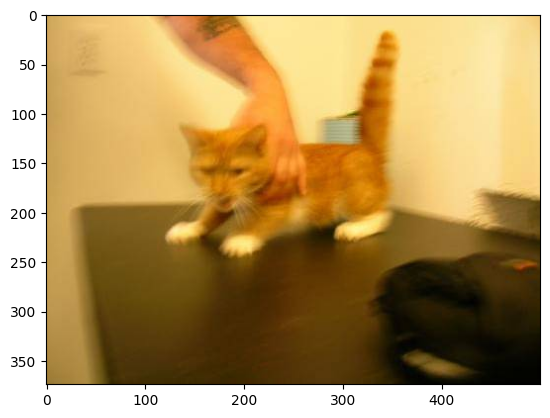

In [ ]:
im = plt.imread("/content/input/Asirra: cat vs dogs/cat.0.jpg")
plt.imshow(im)
plt.show()

In [ ]:
metadata_paths = sorted(glob("/content/input/Asirra: cat vs dogs/cat*.xml"))
images_paths = sorted(glob("/content/input/Asirra: cat vs dogs/cat*.jpg"))

In [ ]:
for metadata_path, image_path in tqdm(zip(metadata_paths, images_paths)):
    if os.stat(image_path).st_size < 100000:
        image = cv2.imread(image_path)

        truth_recangles, truth_label, image_id = extract_ground_truth(metadata_path)

        if truth_label:
            predicted_rectangles = region_proposals(image)
            images_to_file(image, truth_recangles, truth_label, predicted_rectangles, image_id, "./training")

0it [00:00, ?it/s]<ipython-input-4-9583c49abfe6>:27: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
<ipython-input-4-9583c49abfe6>:19: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)
136it [04:46,  1.32s/it]<ipython-input-15-b9d454aaf863>:7: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if truth_label:
550it [18:50,  2.06s/it]


In [ ]:
data_train = keras.utils.image_dataset_from_directory("/content/training", image_size=(227,227))


Found 42057 files belonging to 2 classes.


In [ ]:
data_train.class_names

['cat', 'no_category']

In [ ]:
class_weight = {0: 5, 1: 1}

input_l = keras.layers.Input(shape=(227, 227, 3))
input_layer = keras.layers.Rescaling(1./255)(input_l)
input_layer = keras.layers.ZeroPadding2D((16,16))(input_layer)
input_layer = keras.layers.RandomCrop(227,227)(input_layer)
input_layer = keras.layers.RandomFlip("horizontal")(input_layer)

headModel = keras.applications.MobileNetV2(weights="imagenet", include_top=False,input_tensor=input_layer)

for layer in headModel.layers:
    layer.trainable = False

headModel = headModel.output

baseModel = keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
baseModel = keras.layers.Flatten(name="flatten")(baseModel)
baseModel = keras.layers.Dense(128, activation="relu")(baseModel)
baseModel = keras.layers.Dropout(0.3)(baseModel)
output = keras.layers.Dense(2, activation="softmax")(baseModel)


model = keras.models.Model(inputs=input_l, outputs=output)

9406464/9406464 [==============================] - 0s 0us/step


In [ ]:
model.compile(optimizer=keras.optimizers.Adam(), loss=keras.losses.SparseCategoricalCrossentropy(), metrics=["accuracy"])

history = model.fit(data_train, epochs=10, batch_size=64, class_weight=class_weight)

In [ ]:
model.summary()

In [ ]:
model.save_weights('/content/checkpoints/my_checkpoint')

In [ ]:
shutil.make_archive('checkpoints', 'zip', 'checkpoints')

'/content/checkpoints.zip'

In [ ]:
import zipfile
zip_ref=zipfile.ZipFile('checkpoints.zip','r')
zip_ref.extractall('checkpoints')
zip_ref.close()

In [ ]:
model.load_weights('/content/checkpoints/my_checkpoint')

In [ ]:
prediction_sample = "https://i.ytimg.com/vi/K1Xkt1E7PJY/maxresdefault.jpg"

response = requests.get(prediction_sample)

with open("./prediction.jpg", 'wb') as f:
    f.write(response.content)

prediction = plt.imread("./prediction.jpg")

plt.imshow(prediction)
plt.show()

In [ ]:
prediction = plt.imread("/content/123.png")
plt.imshow(prediction)
plt.show()

In [ ]:
def images_to_file_prediction(image, predicted_rectangles, path="."):
    """Crops boxes and writes images to files."""

    if not os.path.exists(f"{path}/"):
        os.makedirs(f"{path}/")

    i_id = 0

    for predicted_rectangle in predicted_rectangles:
        file_name = f"{path}/{i_id}.jpg"
        cropped_image = image[predicted_rectangle[2]:predicted_rectangle[3], predicted_rectangle[0]:predicted_rectangle[1]]
        img = Image.fromarray(cropped_image, 'RGB')
        img2 = img.resize((227,227), Image.ANTIALIAS)
        img2.save(file_name)
        i_id +=1

In [ ]:
predicton_rectangles = region_proposals(prediction)
images_to_file_prediction(prediction, predicton_rectangles, path="./prediction2/pred")

<ipython-input-20-c063bea86c22>:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img2 = img.resize((227,227), Image.ANTIALIAS)


In [ ]:
# When doing prediction ALWAYS set the shuffle parameter to False. Otherwise you can't trace the order of files correctly.
prediction_data = keras.utils.image_dataset_from_directory("./prediction2", image_size=(227,227), shuffle=False)

# Model prediction
prediction_output = model.predict(prediction_data, batch_size=1)

In [ ]:
def _restructure_rectangles_xy(old_rects):
    """Converts rectangles from (x, y, w, h) to (x1, y1, x2, y2)"""
    x1 = old_rects[:,0]
    x2 = old_rects[:,1]
    y1 = old_rects[:,2]
    y2 = old_rects[:,3]

    rects_new = old_rects.copy()
    rects_new[:,1] = x1
    rects_new[:,0] = y1
    rects_new[:,3] = x2
    rects_new[:,2] = y2
    return rects_new

new_pred_rects = _restructure_rectangles_xy(predicton_rectangles)

In [ ]:
# Method that "prunes away boxes that have high intersection-over-union (IOU) overlap with previously selected boxes" (Tensorflow Docs)
predictions = tf.image.non_max_suppression(new_pred_rects, prediction_output[:,0], max_output_size=3, iou_threshold=0.5)

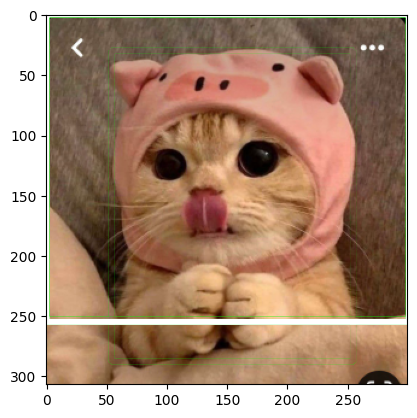

In [ ]:
image = plt.imread("/content/123.png")

for ind_rect in predictions.numpy():
    img_index = int(prediction_data.file_paths[ind_rect].split("/")[-1].split(".")[0])
    rectangle_coordinates = predicton_rectangles[img_index].astype(int)
    rectangled_image = cv2.rectangle(image, (rectangle_coordinates[0], rectangle_coordinates[2]), (rectangle_coordinates[1], rectangle_coordinates[3]), (0, 255, 0), 3)
    plt.imshow(rectangled_image)

plt.show()